In [10]:
# %load ../env.py
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

import matplotlib.text as text
import pandas as pd
import numpy as np
import pylab as pl
import scipy as sp
import sys
import rpy2 
import os 

#Set environment variables


# Set up the local source files
#TOP = '/'.join(os.getcwd().split('/')[:-2])+'/'
#TOP = "/share/home/ishah/ipynb/chiron/genra-analysis/"
TOP = "/share/home/ishah/ipynb/pb/GenRA/"

LIB = TOP+'lib'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

os.environ['PYTHONPATH']=LIB


DAT_DIR = TOP + '/data/'
FIG_DIR = TOP + '/figs/'

if not os.path.exists(DAT_DIR): os.mkdir(DAT_DIR)
if not os.path.exists(FIG_DIR): os.mkdir(FIG_DIR)


from db.mongo import *

DB = openMongo(db='genra_dev_v4')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/usr/local/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load the genra prediction module

In [11]:
from rax.genrapred import *

## Find an example chemical 

In [7]:
C0 = DB.compounds.find_one(dict(name='PFOS'),dict(_id=0,synonyms=0))
sid = C0['dsstox_sid']
C0

{u'casrn': u'1763-23-1',
 u'chemspider_id': 67068,
 u'created_at': datetime.datetime(2017, 4, 24, 20, 32, 19),
 u'dsstox_cid': u'DTXCID1011864',
 u'dsstox_sid': u'DTXSID3031864',
 u'gsid': 31864,
 u'inchi_key': u'YFSUTJLHUFNCNZ-UHFFFAOYSA-N',
 u'iupac': u'Heptadecafluorooctane-1-sulfonic acid',
 u'mol_weight': 500.13,
 u'name': u'PFOS',
 u'pubchem_cid': 74483,
 u'smiles': u'OS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F',
 u'updated_at': datetime.datetime(2017, 8, 30, 19, 10, 40)}

## Run the GenRA Prediction

In [21]:
saveRunGenRA(sid,col_save='pred_is_v1',DB=DB,s0=0.05,k0=10,dbg=False,sel_by='toxp_txrf')

In [22]:
DB.pred_is_v1.count()

226

In [7]:
Hits = pd.DataFrame(runGenRA(sid,DB=DB,s0=0.05,k0=20,dbg=False,sel_by='toxp_txrf')).set_index('out')

/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [8]:
H0=Hits.sort_values(['auc','p_val'],ascending=[True,False]).query("auc>0.1 and p_val<0.5")
H0

,a_p,a_s,a_t,auc,dsstox_sid,fp,k0,n_neg,n_pos,p_val,pred,s0,t0
out,,,,,,,,,,,,,
SUB:Adrenal Gland,0,0.120,None,0.500000,DTXSID8031865,chm_mrgn,20,12,4,0.48,Neg,0.05,0.176260
CHR:Stomach,0,0.232,None,0.500000,DTXSID8031865,chm_mrgn,20,4,3,0.33,Neg,0.05,0.401701
SUB:Seminal Vesicle,0,0.090,None,0.512821,DTXSID8031865,chm_mrgn,20,13,3,0.47,Neg,0.05,0.136390
MGR:Food Consumption,0,0.304,None,0.533333,DTXSID8031865,chm_mrgn,20,5,3,0.48,Neg,0.05,0.366333
SUB:Other,0,0.326,None,0.571429,DTXSID8031865,chm_mrgn,20,14,2,0.27,Neg,0.05,0.157344
SUB:Bone Marrow,0,0.096,None,0.666667,DTXSID8031865,chm_mrgn,20,13,3,0.21,Neg,0.05,0.187438
MGR:Stomach,0,0.115,None,0.666667,DTXSID8031865,chm_mrgn,20,6,2,0.29,Neg,0.05,0.112760
MGR:Mortality,0,0.115,None,0.666667,DTXSID8031865,chm_mrgn,20,6,2,0.28,Neg,0.05,0.112760
DEV:Liver,0,0.112,None,0.666667,DTXSID8031865,chm_mrgn,20,6,2,0.17,Neg,0.05,0.189812


## Visualize predictions

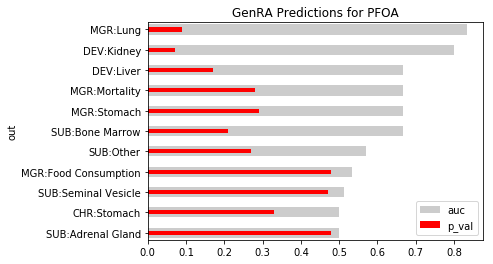

In [9]:
pl.title("GenRA Predictions for %s" % C0['name'])
H0['auc'].plot.barh(color='grey',alpha=0.4,stacked=True)
H0['p_val'].plot.barh(color='red',alpha=1,width=0.2,stacked=True)
pl.legend()

# Parallelize

`ipcluster start --profile=pb_parallel --n=50`


In [12]:
import ipyparallel as PP

RC=PP.Client(profile='pb_parallel')
d_view=RC[:]
lb_view = RC.load_balanced_view()
lb_view.block = True
x=file("../parenv.py",'r').read()
d_view.execute(x)

<AsyncResult: execute>

In [4]:
d_view.map_sync(lambda x: DB.chm_fp.count(),range(10))

[748794,
 748794,
 748794,
 748794,
 748794,
 748794,
 748794,
 748794,
 748794,
 748794]

In [5]:
DB.collection_names()

[u'pred_GH',
 u'logs',
 u'pred_gh',
 u'tox1_fp',
 u'tox_fp',
 u'compounds',
 u'chm_fp',
 u'pred_is_v1',
 u'bio_fp']

In [4]:
ALL_SID = [i['dsstox_sid'] for i in DB.chm_fp.find({},dict(dsstox_sid=1))]

In [13]:
sid = ALL_SID[1000]
sid

u'DTXSID4021684'

In [8]:
saveRunGenRA(sid,col_save='pred_is_v1',DB=DB,s0=0.05,k0=10,dbg=False,sel_by='toxp_txrf')

/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [ ]:
import datetime

WORK=ALL_SID
DB.pred_is_v1.delete_many({})

print "Start ... ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), "tasks = ",len(WORK)
print "DB.pred_is_v1", DB.pred_is_v1.count()

lb_view.map(lambda sid:
            saveRunGenRA(sid,col_save='pred_is_v1',DB=DB,s0=0.05,k0=10,
                         dbg=False,sel_by='toxp_txrf'),
            WORK)

print "DB.pred_is_v1", DB.pred_is_v1.count()
print "End ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), "tasks = ",len(WORK)



Start ...  2018-01-09 12:36:37 tasks =  748794
DB.pred_is_v1 0


In [ ]:
for i in [u'fp', u'n_neg', u'auc',u'a_t', u'dsstox_sid', u'a_p', u'pred', u's0', u't0',
         u'n_pos', u'k0', u'p_val', u'a_s', u'out']:
    print(i+"...")
    DB.pred_is_v1.create_index(i)
    